In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
from sklearn import preprocessing
import time
import seaborn as sns
import re
from gensim.models import word2vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential

from keras.layers import Embedding

# tf.logging.set_verbosity(tf.logging.ERROR)
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

c:\Users\Test\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Load Data

In [2]:
triplets_file = 'train_triplets.txt'
songs_metadata_file = 'unique_tracks.txt'

song_df_1 = pd.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']
# index = len(song_df_1)//5
# song_df_1 = song_df_1[:index]

#Read song  metadata
song_df_2 = pd.read_csv('unique_tracks.txt', sep="<SEP>", names=['track_id', 'song_id', 'artist_name', 'title'])
song_df_2.drop(columns='track_id', inplace=True)

C:\Users\Test\AppData\Local\Temp\ipykernel_11172\640230490.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  song_df_2 = pd.read_csv('unique_tracks.txt', sep="<SEP>", names=['track_id', 'song_id', 'artist_name', 'title'])


In [3]:
song_df_1.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [4]:
song_df_2.head()

,song_id,artist_name,title
0,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [5]:
len(song_df_2.artist_name.unique())

72665

In [6]:
len(song_df_2.title.unique())

702000

### Data Cleaning

In [6]:
le_song_id = preprocessing.LabelEncoder()
le_song_id.fit(song_df_2.song_id)
song_df_2.song_id = le_song_id.transform(song_df_2.song_id)
song_df_1.song_id = le_song_id.transform(song_df_1.song_id)

In [7]:
le_user_id = preprocessing.LabelEncoder()
song_df_1.user_id = le_user_id.fit_transform(song_df_1.user_id)

### Merge two dataset

In [11]:
song_df = pd.merge(song_df_1, \
                   song_df_2.drop_duplicates(['song_id']), \
                   on="song_id", how="left")

In [12]:
index = len(song_df)//20
song_df = song_df.iloc[:index]

In [13]:
song_df

,user_id,song_id,listen_count,artist_name,title
0,732659,17370,1,Jack Johnson,The Cove
1,732659,25443,1,Billy Preston,Nothing from Nothing
2,732659,45995,2,Paco De Lucia,Entre Dos Aguas
3,732659,52765,1,Josh Rouse,Under Cold Blue Stars
4,732659,52840,1,The Dead 60s,Riot Radio (Soundtrack Version)
...,...,...,...,...,...
2418674,138140,786302,1,Train,Marry Me
2418675,138140,816236,1,Usher featuring will.i.am,OMG
2418676,138140,820777,1,Lil Wayne / Eminem,Drop The World
2418677,138140,864745,1,Kings Of Leon,Use Somebody


In [15]:
# song_df.describe(include=[np.int, np.object])
song_df.describe(include=[np.int32, np.int64, np.object_])


,user_id,song_id,listen_count,artist_name,title
count,2418679.000,2418679.000,2418679.000,2418679,2418674
unique,NaN,NaN,NaN,31036,171958
top,NaN,NaN,NaN,Coldplay,Sehr kosmisch
freq,NaN,NaN,NaN,19776,5451
mean,509999.019,508882.160,2.865,NaN,NaN
...,...,...,...,...,...
min,5.000,12.000,1.000,NaN,NaN
25%,256386.000,260972.000,1.000,NaN,NaN
50%,508985.000,517732.000,1.000,NaN,NaN
75%,761578.000,759413.000,3.000,NaN,NaN


In [16]:
song_df = song_df.fillna(value=0)

C:\Users\Test\AppData\Local\Temp\ipykernel_11172\396669975.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(song_df.listen_count, kde=False, rug=False)


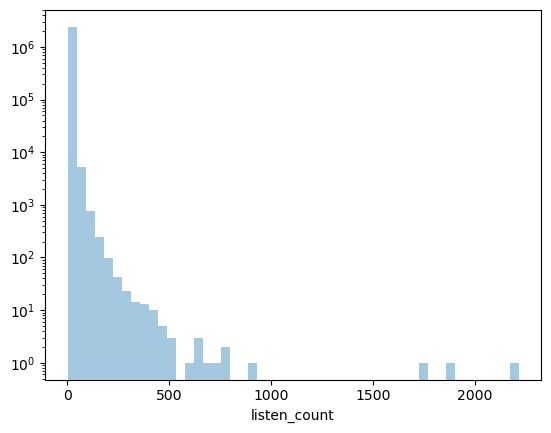

In [18]:
g = sns.distplot(song_df.listen_count, kde=False, rug=False)
g.set_yscale('log')

#### number of unique user

In [19]:
len(pd.unique(song_df.user_id))

50449

#### number of unique song

In [20]:
len(pd.unique(song_df.song_id))

206930

#### check the most popular songs

In [21]:
song_ratings = song_df_2.merge(
    song_df
    .groupby('song_id', as_index=False)
    .agg({'listen_count': ['count', 'mean']})
    .flatten_cols(),
    on='song_id')

sorted_song = (song_ratings[['title', 'listen_count count', 'listen_count mean']].sort_values('listen_count count', ascending=False))

sorted_song.head(10)

,title,listen_count count,listen_count mean
167681,Sehr kosmisch,5451,3.652
23147,Undo,4641,6.758
31565,Dog Days Are Over (Radio Edit),4589,3.814
93090,You're The One,4197,8.355
179717,Revelry,4015,6.755
179177,Secrets,3805,3.775
128370,Horn Concerto No. 4 in E flat K495: II. Romanc...,3507,5.734
165572,Fireflies,3132,3.033
161108,Hey_ Soul Sister,3132,3.268
115875,Tive Sim,2971,3.106


### Data Normalization
Số lượng 'list_count' tối đa là 8277, trong khi số tối thiểu là 0. Phạm vi lớn này sẽ tạo ra vấn đề cho mô hình và yêu cầu chuẩn hóa.

Ở đây, trước tiên nhóm dữ liệu theo người dùng, sau đó chuẩn hóa giá trị listen_count.

In [22]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418679 entries, 0 to 2418678
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       int32 
 1   song_id       int32 
 2   listen_count  int64 
 3   artist_name   object
 4   title         object
dtypes: int32(2), int64(1), object(2)
memory usage: 73.8+ MB


In [23]:
def zscore(x):
    return (x - x.mean()) / x.std()

norm = song_df.groupby('user_id')['listen_count'].transform(zscore)
song_df['listen_count'] = norm

song_df.head()

,user_id,song_id,listen_count,artist_name,title
0,732659,17370,-0.299,Jack Johnson,The Cove
1,732659,25443,-0.299,Billy Preston,Nothing from Nothing
2,732659,45995,0.519,Paco De Lucia,Entre Dos Aguas
3,732659,52765,-0.299,Josh Rouse,Under Cold Blue Stars
4,732659,52840,-0.299,The Dead 60s,Riot Radio (Soundtrack Version)


In [24]:
def min_max(x):
    return (x-x.min()) / (x.max() - x.min())

norm = song_df.groupby('user_id')['listen_count'].transform(min_max)
song_df['listen_count'] = norm

song_df.head()

,user_id,song_id,listen_count,artist_name,title
0,732659,17370,0.000,Jack Johnson,The Cove
1,732659,25443,0.000,Billy Preston,Nothing from Nothing
2,732659,45995,0.143,Paco De Lucia,Entre Dos Aguas
3,732659,52765,0.000,Josh Rouse,Under Cold Blue Stars
4,732659,52840,0.000,The Dead 60s,Riot Radio (Soundtrack Version)


In [25]:
song_df = song_df.fillna(value=0)

In [26]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [27]:
def build_rating_sparse_tensor(song_df):
  indices = song_df[['user_id', 'song_id']].values
  values = song_df['listen_count'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[song_df_1.shape[0], song_df_2.shape[0]])


In [28]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [29]:
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.compat.v1.global_variables_initializer(),
          tf.compat.v1.local_variables_initializer())
      if self._session is None:
        self._session = tf.compat.v1.Session()
        with self._session.as_default():
          self._session.run(tf.compat.v1.global_variables_initializer())
          self._session.run(tf.compat.v1.tables_initializer())
          tf.compat.v1.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [30]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  train_ratings, test_ratings = split_dataframe(ratings)
  
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "song_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 5000: train_error=0.072422, test_error=0.084408

[{'train_error': 0.07242246, 'test_error': 0.08440839}]

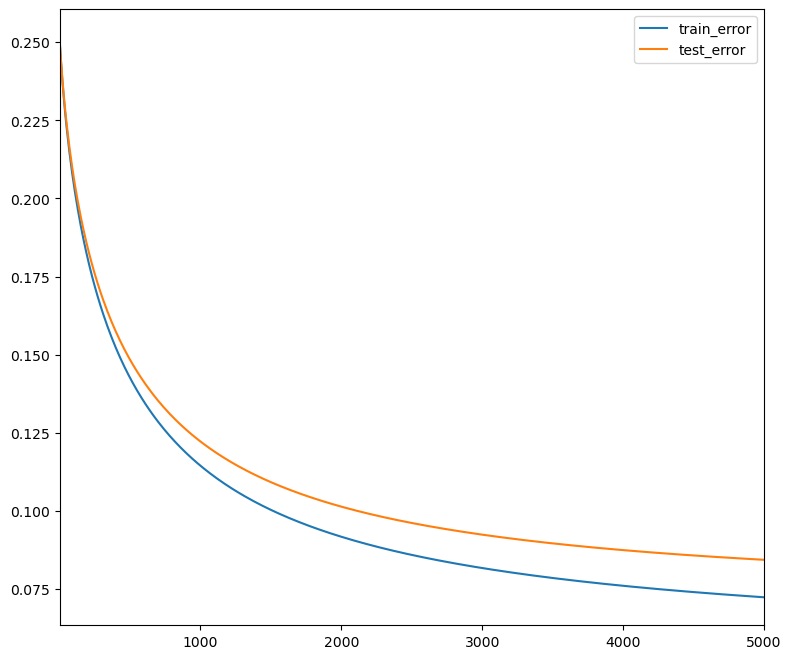

In [31]:
# Build the CF model and train
tf.compat.v1.disable_eager_execution()
model = build_model(song_df, embedding_dim=3, init_stddev=0.5)
model.train(num_iterations=5000, learning_rate=25.)

### Find similar items

In [54]:
music = song_df_2

In [55]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [56]:
def music_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  music[music['title']==title_substring].index.values
  titles = music.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no music with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching music. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  song_id = ids[0]
  scores = compute_scores(
      model.embeddings["song_id"][song_id], model.embeddings["song_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': music['title'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [60]:
music_neighbors(model, "Stronger", COSINE)

Nearest neighbors of : Stronger.
[Found more than one matching music. Other candidates: Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger]


,cosine score,titles
5945,1.000,Stronger
421789,1.000,Too Fly (Featuring Total's Pam) (Clean LP Vers...
268885,1.000,War of Emotions
285686,1.000,Where Do We Go From Here
935304,1.000,The Twist
402660,1.000,African Thing


In [61]:
music_neighbors(model, "Stronger", DOT)

Nearest neighbors of : Stronger.
[Found more than one matching music. Other candidates: Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger, Stronger]


,dot score,titles
64082,3.053,Nomalizo
108806,2.907,Mr. Mutha Fucka
712430,2.893,Vegas
233500,2.851,Marabao_ Directo
760361,2.848,Forever Or Today
763467,2.806,Thank Him


In [62]:
USER_RATINGS = True
def user_recommendations(model, user_id, measure=DOT, exclude_rated=False, k=20):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][user_id], model.embeddings["song_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'song_id': music['song_id'],
        'titles': music['title'],
    })
    if exclude_rated:
      # remove music that are already rated
      rated_music = ratings[ratings.user_id == str(user_id)]["song_id"].values
      df = df[df.song_id.apply(lambda song_id: song_id not in rated_music)]
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [69]:
user_id = 5
if USER_RATINGS:
  user_recommendations(model,user_id, measure=DOT, k=10)

,dot score,song_id,titles
851583,2.779,270338,Let The Door Hit You
666821,2.747,65473,Boys And Girls
200047,2.618,591130,Lock Stock and Barrel - Original
724302,2.574,214630,The Intake Room
960053,2.528,260303,Other Side
477851,2.520,240534,Accident On Third Street
559831,2.510,765308,25 Variations And Fugue On A Theme By G.F. Han...
355694,2.509,934310,Melburn
143316,2.500,176692,Fantasy Pieces_ Op. 12: VII. Dream Visions in ...
834371,2.477,78097,Silueta
